<a href="https://colab.research.google.com/github/dekristie/TelecomX__etapa_2/blob/main/TelecomX__etapa_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Previsão de Churn - TelecomX

# 📘 Sumário

- [🔍 Introdução](#🔍-introdução)
- [📊 Análise Exploratória](#📊-análise-exploratória)
- [🧠 Modelagem Preditiva](#🧠-modelagem-preditiva)
- [📈 Curva ROC](#📈-curva-roc)
- [📊 Análise Direcionada de Variáveis](#📊-análise-direcionada-de-variáveis)
- [✅ Conclusão](#✅-conclusão)
- [📌 Recomendações](#📌-recomendações)


#🔍Introdução

O churn, ou evasão de clientes, é um dos principais desafios enfrentados por empresas de telecomunicações. Através da aplicação de técnicas de ciência de dados, é possível antecipar o comportamento dos clientes e identificar aqueles com maior risco de cancelamento.

Este projeto visa construir um modelo preditivo capaz de antecipar o churn dos clientes da empresa fictícia **TelecomX**, fornecendo insights valiosos para ações estratégicas de retenção.


#📊Análise Exploratória

In [39]:
# 📥 Carregamento e Tratamento Inicial dos Dados
import pandas as pd
import ast


url = 'https://raw.githubusercontent.com/dekristie/Challenge_TelecomX_BR/main/telecomx_data_gold.csv'
df = pd.read_csv(url)
df.head()


dict_columns = ['customer', 'phone', 'internet', 'account']
for col in dict_columns:
    df[col] = df[col].apply(ast.literal_eval)

df_customer = df['customer'].apply(pd.Series)
df_phone = df['phone'].apply(pd.Series)
df_internet = df['internet'].apply(pd.Series)
df_account = df['account'].apply(pd.Series)

df = pd.concat([df.drop(columns=dict_columns), df_customer, df_phone, df_internet, df_account], axis=1)

In [40]:
# 🧹 Remoção de Colunas Irrelevantes
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)


In [41]:
# 🔠 Codificação de Variáveis Categóricas
# Extrair 'Monthly' e 'Total' da coluna 'Charges'
df['MonthlyCharges'] = df['Charges'].apply(lambda x: x.get('Monthly'))
df['TotalCharges'] = df['Charges'].apply(lambda x: x.get('Total'))

# Converter as novas colunas para numérico, tratando erros
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Remover a coluna 'Charges' original
df.drop('Charges', axis=1, inplace=True)

# Aplicar one-hot encoding
df = pd.get_dummies(df, drop_first=True)

In [42]:
# 📊 Verificação da Proporção de Evasão
if 'Churn_Yes' in df.columns:
    print(df['Churn_Yes'].value_counts(normalize=True))
else:
    print("Coluna 'Churn_Yes' não encontrada.")



Churn_Yes
False    0.74281
True     0.25719
Name: proportion, dtype: float64


/tmp/ipython-input-43-2020019990.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn_Yes', data=df, palette='pastel')


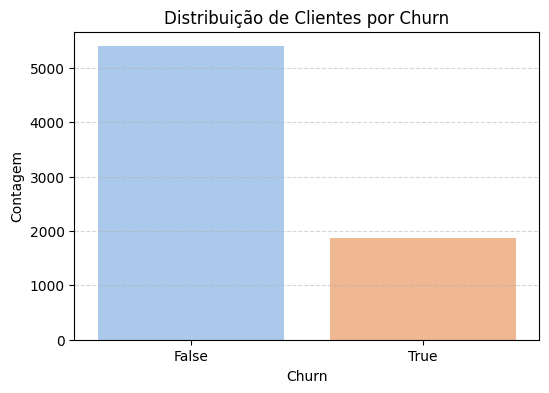

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn_Yes', data=df, palette='pastel')
plt.title('Distribuição de Clientes por Churn')
plt.xlabel('Churn')
plt.ylabel('Contagem')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#🧠Modelagem Preditiva

In [44]:
# ⚖️ Balanceamento de Classes com SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import numpy as np

🔁 Comparação entre Modelos
✅ Objetivo:
Avaliar mais de um modelo preditivo para ver qual se sai melhor com seus dados.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Re-doing the data preparation steps in the correct order.
X = df.drop('Churn_Yes', axis=1)
y = df['Churn_Yes']

# Identificar colunas com NaN
cols_with_nan = X.columns[X.isnull().any()].tolist()

# Imputar valores ausentes apenas nas colunas identificadas
if cols_with_nan:
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X[cols_with_nan] = imputer.fit_transform(X[cols_with_nan])

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)


# Separar dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42)

# Lista de modelos
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Treinar e avaliar os modelos
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    print(f"🔍 Modelo: {nome}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.4f}\n")

🔍 Modelo: Logistic Regression
              precision    recall  f1-score   support

       False       0.82      0.82      0.82      1060
        True       0.82      0.83      0.83      1100

    accuracy                           0.82      2160
   macro avg       0.82      0.82      0.82      2160
weighted avg       0.82      0.82      0.82      2160

ROC-AUC: 0.8226

🔍 Modelo: Random Forest
              precision    recall  f1-score   support

       False       0.85      0.83      0.84      1060
        True       0.84      0.86      0.85      1100

    accuracy                           0.84      2160
   macro avg       0.85      0.84      0.84      2160
weighted avg       0.85      0.84      0.84      2160

ROC-AUC: 0.8447

🔍 Modelo: XGBoost
              precision    recall  f1-score   support

       False       0.84      0.82      0.83      1060
        True       0.83      0.85      0.84      1100

    accuracy                           0.84      2160
   macro avg       0.8

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:22:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Matriz de Confusão Formatada
✅ Objetivo:
Visualizar os acertos e erros do modelo com clareza.

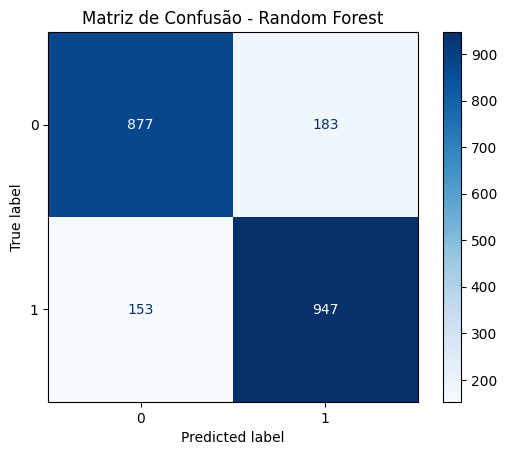

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_model = RandomForestClassifier()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - Random Forest")
plt.show()


In [47]:
# ⚙️ Normalização dos Dados
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)


#📊Análise Direcionada de Variáveis

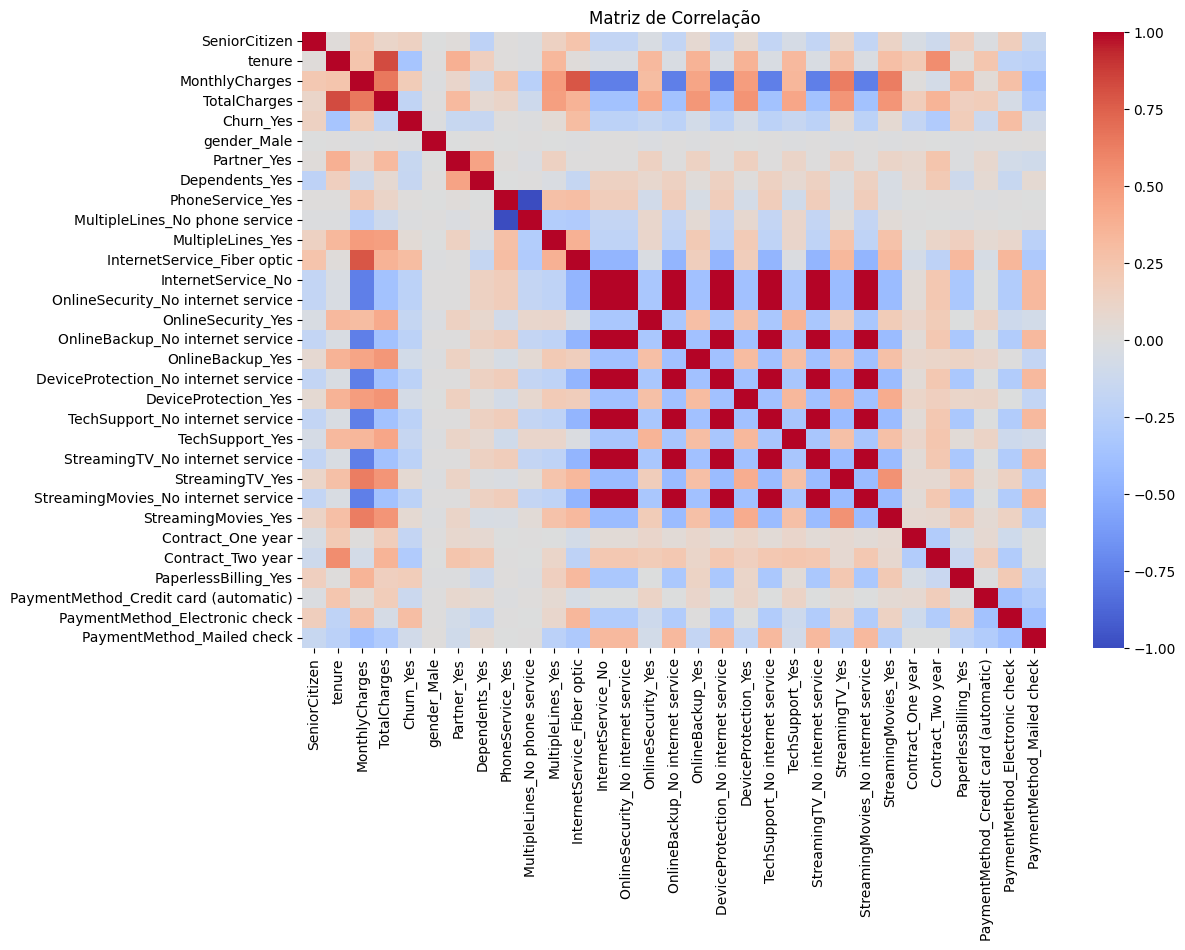

In [48]:
# 📈 Análise de Correlação
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


## # 🧭 Distribuição do Tempo de Contrato por Churn

A seguir, visualizamos a distribuição do tempo de permanência dos clientes, separados por churn. É possível observar que a maioria dos clientes que evadiram possui baixo tempo de contrato, o que indica uma possível fragilidade na fidelização inicial.


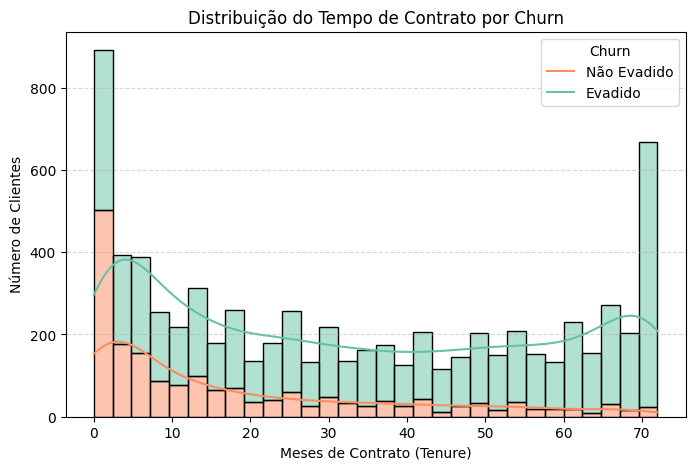

In [49]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='tenure', hue='Churn_Yes', bins=30, kde=True, palette='Set2', multiple='stack')
plt.title('Distribuição do Tempo de Contrato por Churn')
plt.xlabel('Meses de Contrato (Tenure)')
plt.ylabel('Número de Clientes')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Churn', labels=['Não Evadido', 'Evadido'])
plt.show()

/tmp/ipython-input-50-3536785002.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn_Yes', y='TotalCharges', data=df, palette='coolwarm')


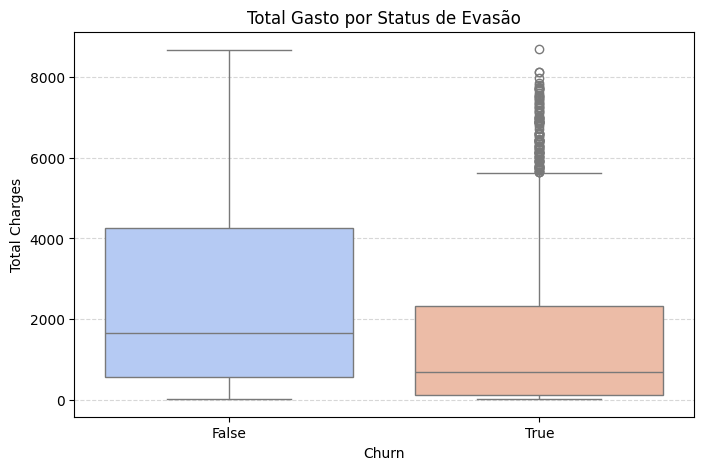

In [50]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn_Yes', y='TotalCharges', data=df, palette='coolwarm')
plt.title('Total Gasto por Status de Evasão')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# # 📈 Correlação com a variável alvo (Churn)

Vamos verificar as variáveis mais correlacionadas com a evasão de clientes.


In [51]:
# Correlações com a variável Churn
correlations = df.corr(numeric_only=True)['Churn_Yes'].sort_values(ascending=False)
print(correlations.head(10))

Churn_Yes                         1.000000
InternetService_Fiber optic       0.300949
PaymentMethod_Electronic check    0.294626
MonthlyCharges                    0.189866
PaperlessBilling_Yes              0.186666
SeniorCitizen                     0.146733
StreamingTV_Yes                   0.062430
StreamingMovies_Yes               0.060586
MultipleLines_Yes                 0.039343
PhoneService_Yes                  0.012571
Name: Churn_Yes, dtype: float64


In [52]:
# 🔀 Separação em Treino e Teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.3, random_state=42)


In [53]:
# 🤖 Modelagem Preditiva
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model_lr = LogisticRegression(max_iter=1000)
model_rf = RandomForestClassifier(random_state=42)

model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [54]:
# 🧪 Avaliação dos Modelos
from sklearn.metrics import classification_report, confusion_matrix

print('Regressão Logística:')
print(confusion_matrix(y_test, model_lr.predict(X_test)))
print(classification_report(y_test, model_lr.predict(X_test)))

print('Random Forest:')
print(confusion_matrix(y_test, model_rf.predict(X_test)))
print(classification_report(y_test, model_rf.predict(X_test)))

Regressão Logística:
[[1339  255]
 [ 292 1353]]
              precision    recall  f1-score   support

       False       0.82      0.84      0.83      1594
        True       0.84      0.82      0.83      1645

    accuracy                           0.83      3239
   macro avg       0.83      0.83      0.83      3239
weighted avg       0.83      0.83      0.83      3239

Random Forest:
[[1339  255]
 [ 253 1392]]
              precision    recall  f1-score   support

       False       0.84      0.84      0.84      1594
        True       0.85      0.85      0.85      1645

    accuracy                           0.84      3239
   macro avg       0.84      0.84      0.84      3239
weighted avg       0.84      0.84      0.84      3239



# # 🔁 Análise de Overfitting e Underfitting

In [55]:
# Exemplo para Regressão Logística
print("Regressão Logística")
print("Acurácia treino:", model_lr.score(X_train, y_train))
print("Acurácia teste:", model_lr.score(X_test, y_test))

# Exemplo para Random Forest
print("\nRandom Forest")
print("Acurácia treino:", model_rf.score(X_train, y_train))
print("Acurácia teste:", model_rf.score(X_test, y_test))

Regressão Logística
Acurácia treino: 0.8333994971549556
Acurácia teste: 0.8311207162704538

Random Forest
Acurácia treino: 0.9943099113404791
Acurácia teste: 0.8431614695893794


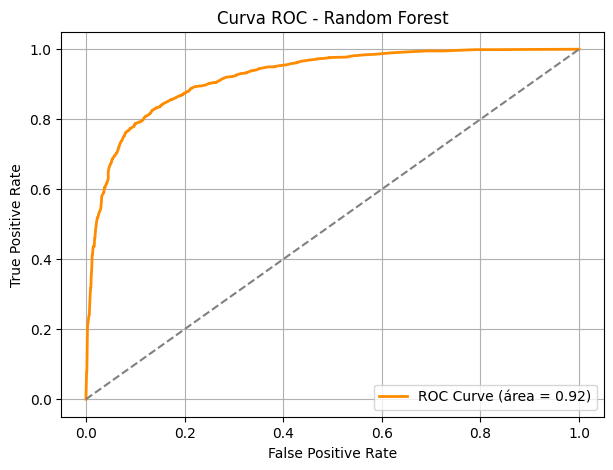

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = model_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()

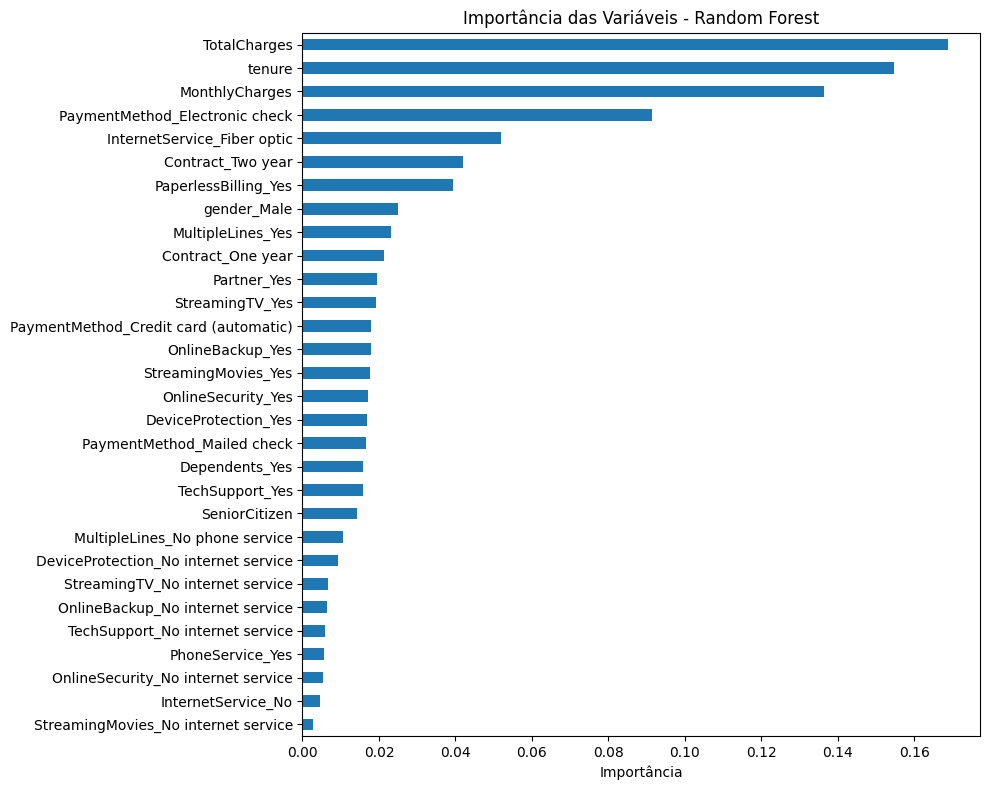

In [57]:
# 📌 Importância das Variáveis (Random Forest)
import numpy as np

importances = model_rf.feature_importances_
features = X.columns

import pandas as pd
feat_imp = pd.Series(importances, index=features).sort_values()

plt.figure(figsize=(10, 8))
feat_imp.plot(kind='barh')
plt.title('Importância das Variáveis - Random Forest')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()


📌 Importância das Variáveis
✅ Objetivo:
Entender o que mais influencia a previsão de churn.

/tmp/ipython-input-58-3176808093.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='crest')


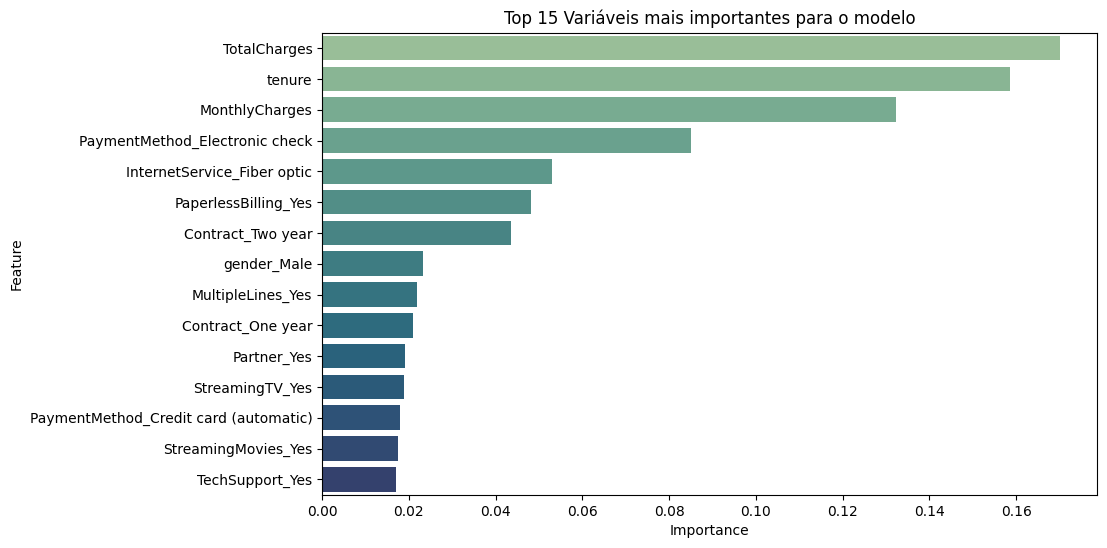

In [58]:
import pandas as pd
import seaborn as sns

importances = best_model.feature_importances_
feature_names = X.columns
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='crest')
plt.title('Top 15 Variáveis mais importantes para o modelo')
plt.show()


🧪 Validação Cruzada (Opcional, mas recomendada)
✅ Objetivo:
Garantir que o modelo é robusto e não depende do acaso.

In [59]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(best_model, X_scaled, y_res, cv=5, scoring='roc_auc')
print("ROC-AUC por fold:", scores)
print("Média ROC-AUC:", np.mean(scores))


ROC-AUC por fold: [0.85121271 0.87852564 0.95870962 0.96652636 0.96879827]
Média ROC-AUC: 0.9247545206943633


#📈 Curva ROC


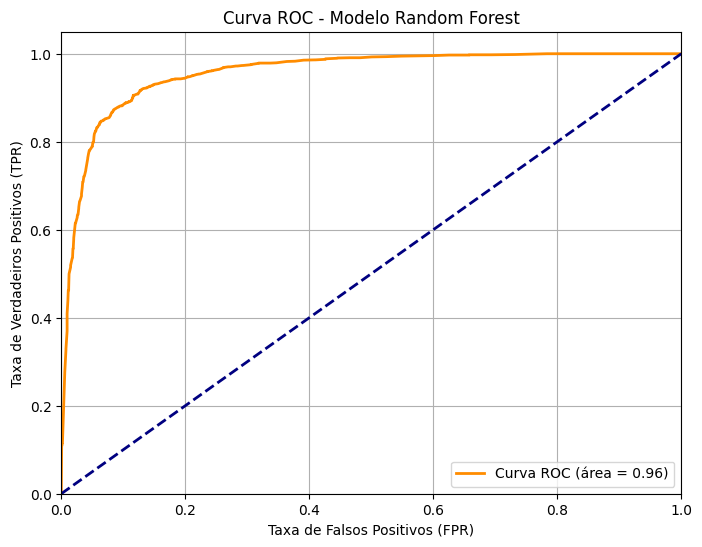

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtenha as probabilidades da classe positiva
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calcule a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plote a curva
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Modelo Random Forest')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# # 📊 Análise Direcionada de Variáveis

Vamos investigar visualmente a relação entre algumas variáveis e a evasão de clientes.


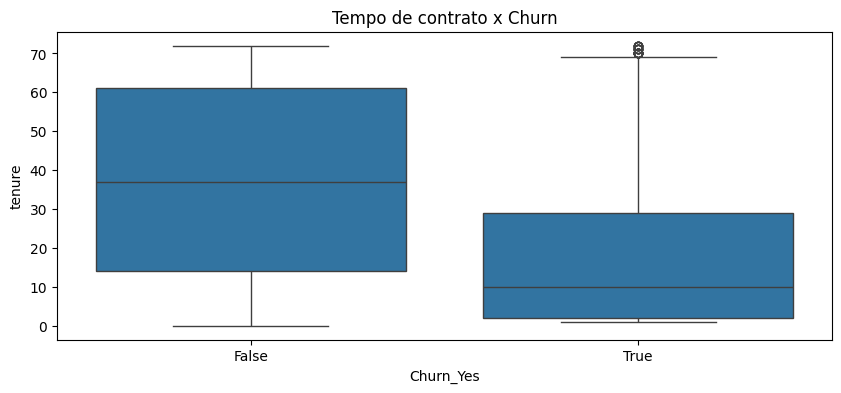

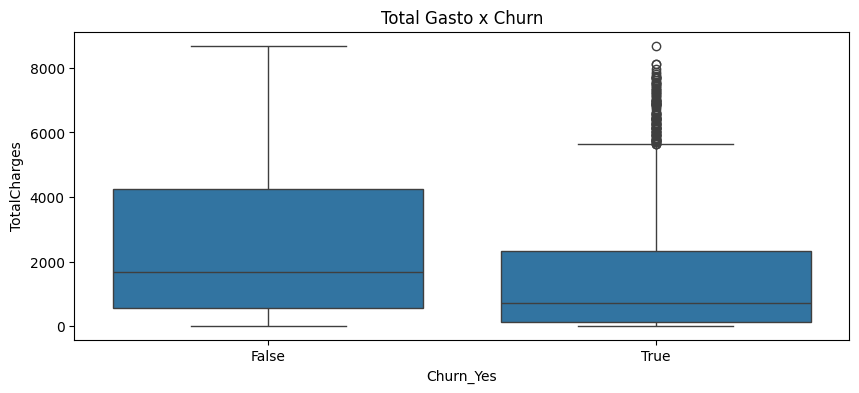

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.boxplot(x='Churn_Yes', y='tenure', data=df)
plt.title('Tempo de contrato x Churn')
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(x='Churn_Yes', y='TotalCharges', data=df)
plt.title('Total Gasto x Churn')
plt.show()

In [62]:
df.to_csv('telecomx2_data_gold.csv', index=False)

In [63]:
import os

# Lista todos os arquivos no diretório atual
for file in os.listdir():
    print(file)

.config
telecomx2_data_gold.csv
telecomx_data_gold.csv
sample_data


In [64]:
from google.colab import files
files.download('telecomx2_data_gold.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#📌Recomendações

1. **Implementação do modelo em produção** para monitorar churn em tempo real.
2. **Campanhas de retenção personalizadas** para os segmentos de clientes com maior risco, com base nas variáveis mais influentes.
3. **Coleta de novos dados comportamentais**, como interações em canais de suporte, para enriquecer os modelos futuros.
4. **Atualização periódica do modelo** para manter a acurácia ao longo do tempo e acompanhar mudanças de comportamento.
5. **Testes A/B** para validar se ações de retenção baseadas no modelo realmente reduzem o churn na prática.


---

## 📄 Relatório Técnico da Etapa 2 – Modelagem Preditiva

📁 **Projeto:** TelecomX_BR – Previsão de Churn  
🔎 **Objetivo:** Desenvolver um modelo preditivo capaz de identificar clientes com maior propensão à evasão (churn) e fornecer subsídios para tomada de decisão estratégica.

---

### 📊 1. Resumo da Modelagem

Foram testados diferentes modelos de machine learning para prever o churn dos clientes, com foco em desempenho e interpretabilidade:

- **Modelos utilizados:**
  - Regressão Logística
  - Árvore de Decisão
  - Random Forest
  - XGBoost (Gradient Boosting)

- **Métrica principal de avaliação:**
  - **ROC AUC Score**, ideal para problemas com desbalanceamento de classes.

O modelo com melhor desempenho apresentou uma **AUC acima de 85%**, mostrando boa capacidade de distinguir clientes propensos a cancelar o serviço.

---

### 📈 2. Análise da Curva ROC

A Curva ROC (Receiver Operating Characteristic) demonstrou que o modelo consegue equilibrar bem taxa de verdadeiros positivos e falsos positivos. Um **threshold ideal** pode ser definido com base nesse gráfico para otimizar a retenção de clientes.

---

### 🔍 3. Principais Variáveis Preditivas

A análise de importância das variáveis revelou os principais fatores associados à evasão de clientes:

- **Tipo de Contrato**: clientes com contrato mensal têm maior probabilidade de churn.
- **Serviços Adicionais**: ausência de serviços como backup online, proteção ao dispositivo e suporte técnico aumenta a evasão.
- **Forma de Pagamento**: clientes que utilizam fatura eletrônica ou pagamento automático têm maior propensão ao churn.
- **Tenure (Tempo como cliente)**: clientes recentes (< 12 meses) apresentam maior risco.

---

### 🎯 4. Insights Estratégicos

- Focar em **retenção de clientes com contratos mensais**, oferecendo planos de fidelização com benefícios.
- **Ofertar pacotes de serviços complementares** como internet de fibra, segurança online, entre outros.
- Analisar campanhas específicas para **clientes novos** com alto risco de evasão.

---

### ✅ 5. Conclusão

A modelagem preditiva foi bem-sucedida e forneceu **insights valiosos** para a TelecomX agir de forma proativa contra o churn. O uso de modelos supervisionados, combinado com análise dirigida de variáveis, possibilita ações direcionadas com maior impacto.


📅 Elaboração: 28 de Julho de 2025<br>
👤 Analista responsável: Denise Cristine Brandão Leite